# Cleaning up gene expression and outlier removal

Some series are clear outliers in the gene expression. Those are best removed if possible. Normal batch effect correction is not advisable. Here is an example of identifying outliers in R and then applying batch effect removal on the Series level for the remaining samples.

## Plotting sample similarity

We can calculate the correlation of samples to each other and identify series that seem to be outliers from the rest.

In [11]:
library("rhdf5")
library("tools")
library("dendextend")
library("preprocessCore")
library("sva")
library("vioplot")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [12]:
res = load("spleen_expression.rda")

In [13]:
res

[1] "expression" "series"

In [14]:
dim(expression)

[1] 32544   407

The gene counts between samples can vary. Some form of normalization should be performed. Here we apply quantile normalization that will force the expression distribution to be the same for all samples.

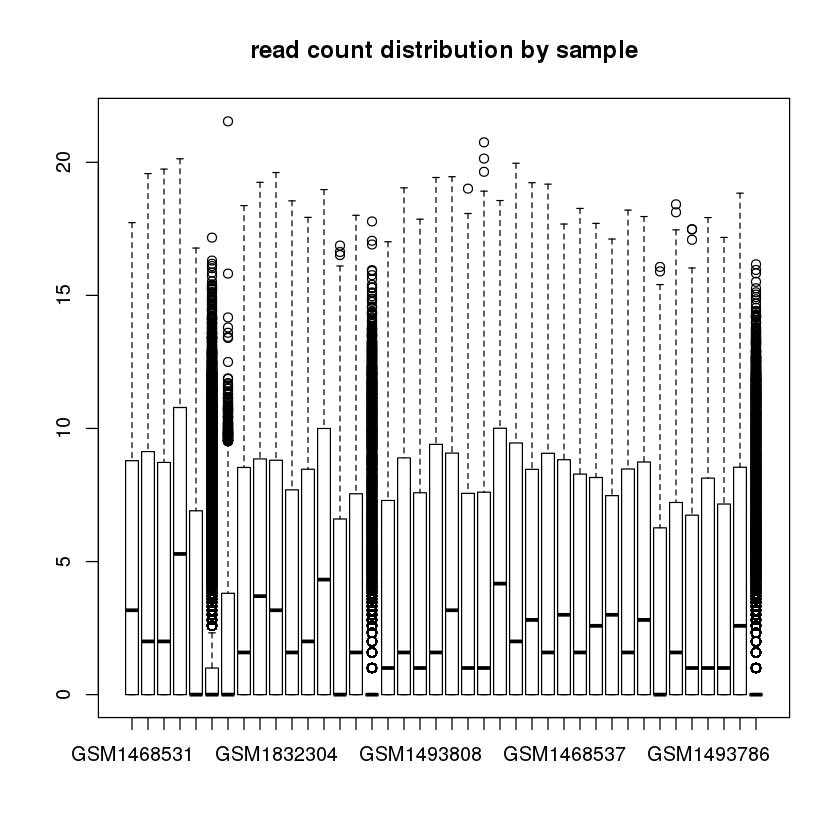

In [56]:
boxplot(log2(1+expression[,sample(1:ncol(expression), 40)]), main="read count distribution by sample")

In [24]:
exp = normalize.quantiles(log2(1+expression))
dimnames(exp) = dimnames(expression)

In [57]:
head(exp)

,GSM1088727,GSM1339956,GSM1339958,GSM2026116,GSM1339955,GSM994535,GSM2067978,GSM1936675,GSM1366910,GSM1339960,⋯,GSM2464129,GSM2464130,GSM2496324,GSM2496318,GSM2496317,GSM2496322,GSM2496319,GSM2496321,GSM2496320,GSM2496323
0610007P14RIK,9.63094098536127,9.07254777745184,9.26399380364379,10.4713954900474,9.16321101689191,9.21142833522663,8.09940482236154,8.28707160721325,9.37396803858809,8.92945571957117,⋯,8.08488124663448,7.99431789742377,7.8713390002555,7.72817820929747,7.75006303303855,7.76105473454717,8.14264315263986,7.99808444545972,8.10052536266361,8.25495950991492
0610009B22RIK,7.06750777765983,6.37023737462521,7.05085376082665,6.82112707962385,6.57320534372377,5.70224389441278,5.7264980684408,6.26096616652237,7.28685665497987,6.33258840132522,⋯,4.71634026011023,4.61435986265418,3.70455886517443,3.72347958330805,1.98435898557579,0.0296727655947195,2.82554506286755,3.26405961215185,0.038236467872779,4.30430664423619
0610009L18RIK,3.92061040001284,3.97429262207382,3.81142379807875,3.41487411082089,4.60653586331457,4.44174160436766,2.37468207061245,5.21708445407083,3.39385236293238,2.36383600768249,⋯,3.89080775992518,3.73470641010117,0.0194272496206597,0.0406934703297815,0.698381328898773,2.77556388467483,3.21616592056306,3.76678420015802,5.15181312745837,4.02973614843003
0610009O20RIK,9.49093306247956,9.40924640605444,9.46323731093644,9.44516327568397,9.48182260279593,8.69984285683286,9.01668163039893,9.89149625532106,9.19221940267954,9.13301935813953,⋯,8.95241596696537,8.7396265997575,8.67266344136375,8.5020663480512,8.45868228039789,8.55329294092101,9.03371753307931,8.50149498477737,8.56121117150341,8.70735780862509
0610010F05RIK,7.80989779570172,8.24470084120278,8.26033268802829,9.62259361387349,7.99020886727399,7.06957617330752,7.30575574677208,7.28333065272756,9.79901248232353,7.76904460916553,⋯,6.65231265474833,6.29874440054845,7.55257453339614,7.68706616450857,7.5731603675777,7.84167922585422,7.41037427073555,7.40883515099795,8.02522313399952,7.59143658230137
0610010K14RIK,9.50963553279628,9.12541509388386,9.52873488507978,9.17875476416631,9.2285334329649,8.92832487049515,7.72672606080004,9.6132570086895,9.43243245648414,8.99474553827167,⋯,9.1460562038552,9.10379866824727,8.13845094800955,9.17059356398657,8.51990549572125,8.55329294092101,8.4988968103643,8.49406253759506,8.73797100158173,8.80908609438858


## Identify outlier samples 

Some samples are different. Here we calculate pairwise correlation and plot a dendrogram to see which samples we might consider to remove. Here we cut the dendrogram tree at 0.25 and keep the largest cluster.

In [26]:
cc = cor(exp)

In [27]:
dend <- as.dendrogram(hclust(as.dist(1-cc)))

In [29]:
useries = unique(series)
series_match = useries[match(series, useries)]

In [35]:
colos <- colorspace::rainbow_hcl(length(useries), c = 160, l  = 50)
names(colos) = useries
series_color <- colos[series_match]

In [36]:
clu = cutree(dend, h=0.25)
labels_colors(dend) <- series_color[order.dendrogram(dend)]
dend <- color_branches(dend, h = 0.25)

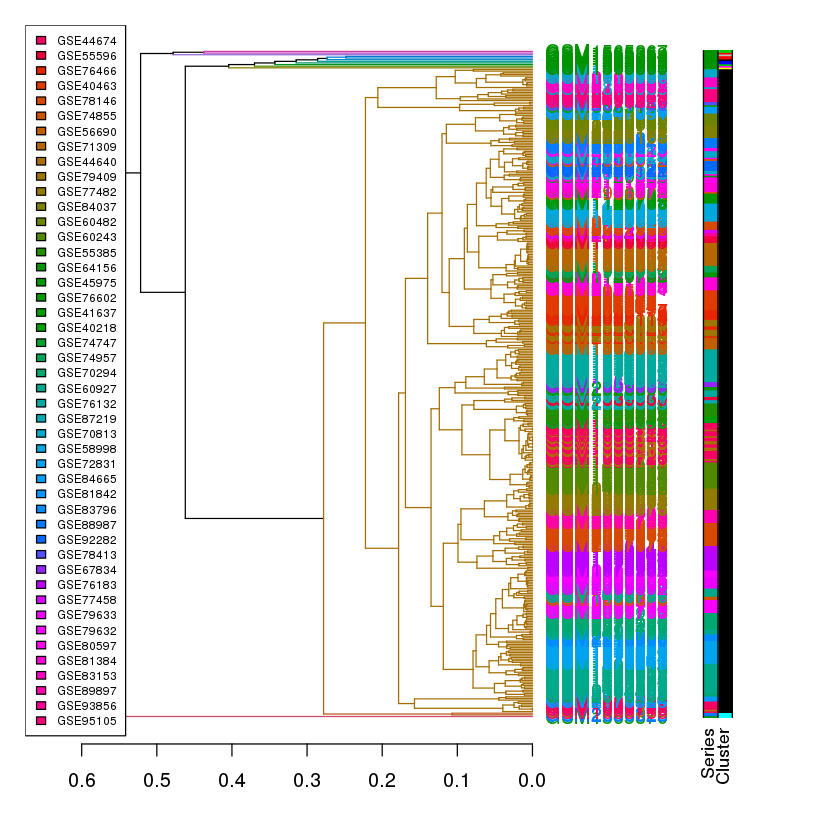

In [37]:
par(mar = c(4,1,1,12))
plot(dend, horiz = TRUE)
colored_bars(cbind(clu, series_color), dend, rowLabels = c("Cluster", "Series"), horiz = TRUE)
legend("topleft", legend = useries, fill = colos, bg="white", cex=0.6)

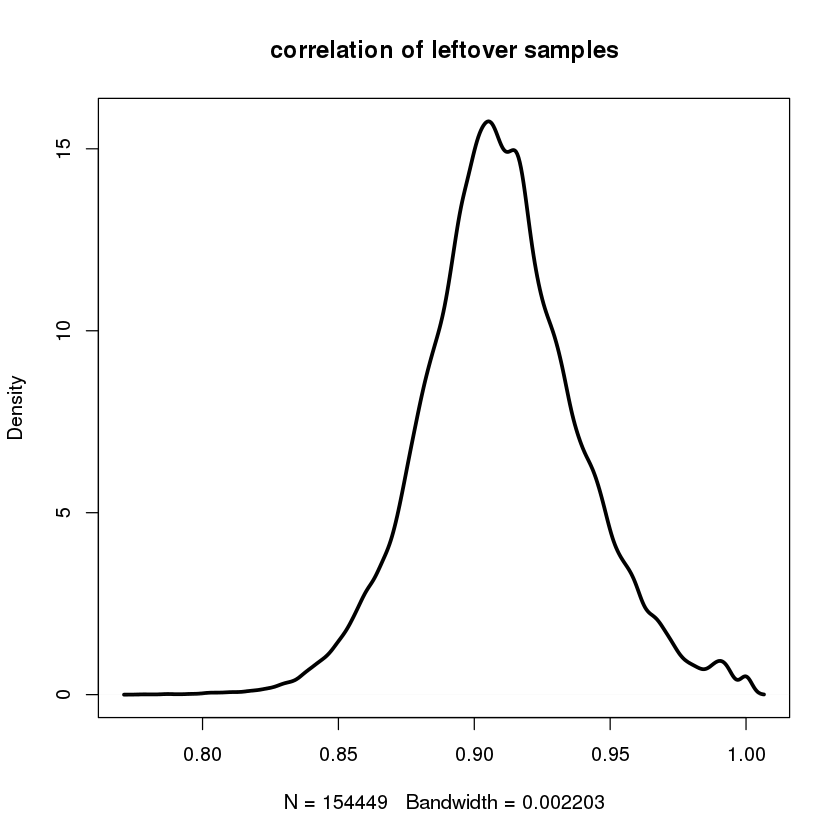

In [38]:
largest_cluster = names(rev(sort(table(clu))))[1]
ww = which(clu == largest_cluster)
plot(density(cor(exp[,ww])), lwd=3, main="correlation of leftover samples")

In [40]:
reduced_expression = exp[,ww]
reduced_series = series[ww]

## Batch effect removal with Combat SVA

By identifying series labels as confounders of gene expression we can now homogenize the gene expression accross series.

In [44]:
batchid = match(reduced_series, unique(reduced_series))
correctedExpression <- ComBat(dat=reduced_expression, batch=batchid, par.prior=TRUE, prior.plots=FALSE)

Found 45 batches
Note: one batch has only one sample, setting mean.only=TRUE
Adjusting for 0 covariate(s) or covariate level(s)
Standardizing Data across genes
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data


In [ ]:
cc = cor(correctedExpression)
dend <- as.dendrogram(hclust(as.dist(1-cc)))
useries = unique(reduced_series)
series_match = useries[match(reduced_series, useries)]
colos <- colorspace::rainbow_hcl(length(useries), c = 160, l  = 50)
names(colos) = useries
series_color <- colos[series_match]
clu = cutree(dend, h=0.25)
labels_colors(dend) <- series_color[order.dendrogram(dend)]
dend <- color_branches(dend, h = 0.25)

par(mar = c(4,1,1,12))
plot(dend, horiz = TRUE)
colored_bars(cbind(clu, series_color), dend, rowLabels = c("Cluster", "Series"), horiz = TRUE)
legend("topleft", legend = useries, fill = colos, bg="white", cex=0.6)

After the batch effect removal (series are batches) the variability accross samples is significanlty reduced. The pairwise correlation of the gene expression is higher as shown in the plot below.

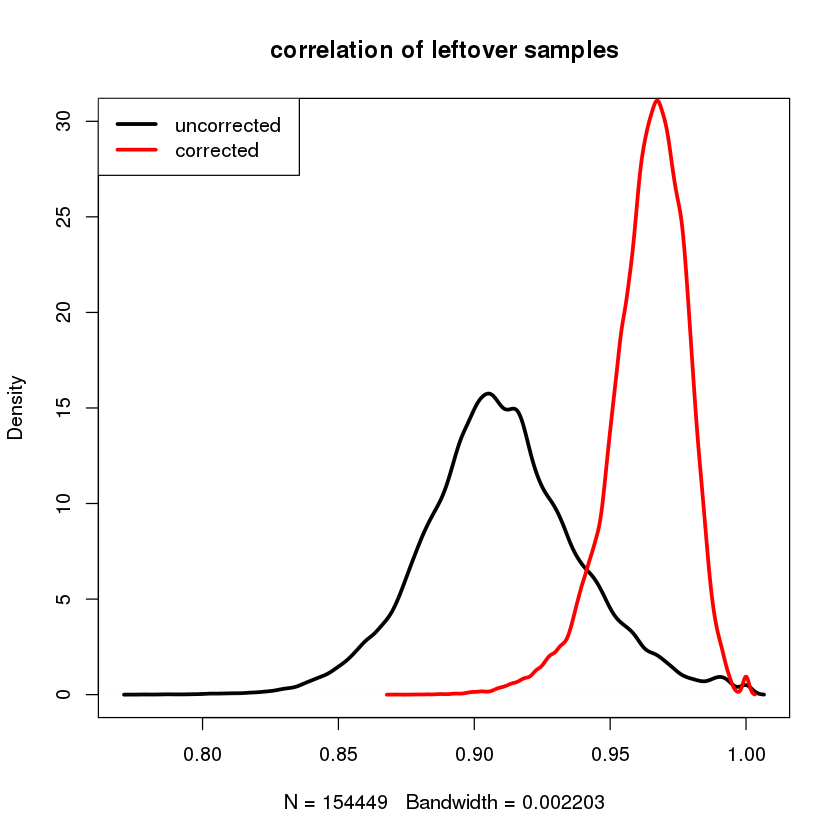

In [54]:
plot(density(cor(exp[,ww])), lwd=3, main="correlation of leftover samples", ylim=c(0,30))
lines(density(cor(correctedExpression)), lwd=3, main="correlation of leftover samples", col="red")
legend("topleft", legend=c("uncorrected","corrected"), lty=1, lwd=3, col=c("black","red"))

This resulting gene expression should be more reliable. Combat also supports more complicated confounder removal. For this look at specific instructions in the SVA manual.